<a href="https://colab.research.google.com/github/FrenchFreis/CCMACLRL_EXERCISES_COM222ML/blob/main/EXERCISE7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [567]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [568]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [569]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

**Validation Set**

Use this set to evaluate your model

In [570]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [571]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [572]:
df_train.head(10)

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [573]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [574]:
df_train.isnull().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [575]:
df_train.duplicated().sum()

0

5. Check how many rows belong to each class

In [576]:
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [577]:
df_train.drop_duplicates()

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
...,...,...
21768,Marcos Talunan Marcos Magnanakaw,1
21769,Grabe kayo kay binay ??????????,0
21770,[USERNAME] Cnu ba naman ang hindImabibighani s...,0
21771,RT [USERNAME]: Tabi tabi yung mga nagsasabing ...,1


7. Remove rows with NaN values

In [578]:
df_train.dropna()

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
...,...,...
21768,Marcos Talunan Marcos Magnanakaw,1
21769,Grabe kayo kay binay ??????????,0
21770,[USERNAME] Cnu ba naman ang hindImabibighani s...,0
21771,RT [USERNAME]: Tabi tabi yung mga nagsasabing ...,1


8. Convert all text to lowercase

In [579]:
df_train['text']=df_train['text'].str.lower()
df_train

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali na sumunod ang patalastas ng n...,1
2,bet ko. pula ang kulay ng posas,1
3,[username] kakampink,0
4,bakit parang tahimik ang mga pink about doc wi...,1
...,...,...
21768,marcos talunan marcos magnanakaw,1
21769,grabe kayo kay binay ??????????,0
21770,[username] cnu ba naman ang hindimabibighani s...,0
21771,rt [username]: tabi tabi yung mga nagsasabing ...,1


9. Remove digits, URLS and special characters

In [580]:
df_train['text']=(df_train['text']
  .str.replace(r"\n","",regex = True)
  .str.replace(r"\d+","",regex = True)
  .str.replace(r'[\$\d+\d+\$]',"",regex = True)
  .str.replace(r'\d+[\.\/-]\d+[\.\/-]\d+','',regex = True)
  .str.replace(r'[^\x00-\x7f]',r' ',regex = True)
  .str.replace(r'[^\w\s]','',regex = True)
  .str.replace(r'https?:\/\/.*[\r\n]*', '',regex = True))

df_train

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali na sumunod ang patalastas ng n...,1
2,bet ko pula ang kulay ng posas,1
3,username kakampink,0
4,bakit parang tahimik ang mga pink about doc wi...,1
...,...,...
21768,marcos talunan marcos magnanakaw,1
21769,grabe kayo kay binay,0
21770,username cnu ba naman ang hindimabibighani sa ...,0
21771,rt username tabi tabi yung mga nagsasabing par...,1


In [581]:
df_train.head(20)

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali na sumunod ang patalastas ng n...,1
2,bet ko pula ang kulay ng posas,1
3,username kakampink,0
4,bakit parang tahimik ang mga pink about doc wi...,1
5,ang sinungaling sa umpisa ay sinungaling hangg...,1
6,leni kiko,0
7,nahiya si binay sa makati kaya dito na lang sa...,1
8,another reminderhalalan,0
9,username maybe because vp leni sen kiko and th...,0


10. Remove stop words

In [582]:
stopwords_list_og = [
    'akin', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano', 'anumang', 'apat', 'at', 'atin', 'ating', 'ay',
    'bababa', 'bago', 'bakit', 'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din', 'dito', 'doon', 'gagawin', 'gayunman',
    'ginagawa', 'ginawa', 'ginawang', 'gumawa', 'gusto', 'habang', 'hanggang', 'hindi', 'huwag', 'iba', 'ibaba', 'ibabaw',
    'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan', 'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyong', 'ka',
    'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang', 'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa',
    'karamihan', 'katiyakan', 'katulad', 'kaya', 'kaysa', 'ko', 'kong', 'kulang', 'kumuha', 'kung', 'laban', 'lahat',
    'lamang', 'likod', 'lima', 'maaari', 'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat', 'masyado',
    'may', 'mayroon', 'mga', 'minsan', 'mismo', 'mula', 'muli', 'na', 'nabanggit', 'naging', 'nagkaroon', 'nais',
    'nakita', 'namin', 'napaka', 'narito', 'nasaan', 'ng', 'ngayon', 'ni', 'nila', 'nilang', 'nito', 'niya', 'niyang',
    'noon', 'o', 'pa', 'paano', 'pababa', 'paggawa', 'pagitan', 'pagkakaroon', 'pagkatapos', 'palabas', 'pamamagitan',
    'panahon', 'pangalawa', 'para', 'paraan', 'pareho', 'pataas', 'pero', 'pumunta', 'pumupunta', 'sa', 'saan', 'sabi',
    'sabihin', 'sarili', 'sila', 'sino', 'siya', 'tatlo', 'tayo', 'tulad', 'tungkol', 'una', 'walang', 'akin', 'aking',
    'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano', 'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'bababa', 'bago',
    'bakit', 'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din', 'dito', 'doon', 'gagawin', 'gayunman', 'ginagawa',
    'ginawa', 'ginawang', 'gumawa', 'gusto', 'habang', 'hanggang', 'hindi', 'huwag', 'iba', 'ibaba', 'ibabaw', 'ibig',
    'ikaw', 'ilagay', 'ilalim', 'ilan', 'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyong', 'ka', 'kahit',
    'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang', 'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan',
    'katiyakan', 'katulad', 'kaya', 'kaysa', 'ko', 'kong', 'kulang', 'kumuha', 'kung', 'laban', 'lahat', 'lamang', 'likod',
    'lima', 'maaari', 'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat', 'masyado', 'may', 'mayroon', 'mga',
    'minsan', 'mismo', 'mula', 'muli', 'na', 'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'namin', 'napaka',
    'narito', 'nasaan', 'ng', 'ngayon', 'ni', 'nila', 'nilang', 'nito', 'niya', 'niyang', 'noon', 'o', 'pa', 'paano',
    'pababa', 'paggawa', 'pagitan', 'pagkakaroon', 'pagkatapos', 'palabas', 'pamamagitan', 'panahon', 'pangalawa', 'para',
    'paraan', 'pareho', 'pataas', 'pero', 'pumunta', 'pumupunta', 'sa', 'saan', 'sabi', 'sabihin', 'sarili', 'sila',
    'sino', 'siya', 'tatlo', 'tayo', 'tulad', 'tungkol', 'una', 'walang', 'ba', 'eh', 'kasi', 'lang', 'mo', 'naman',
    'opo', 'po', 'si', 'talaga', 'yung'
]

unique_stopwords = list(set(stopwords_list_og))
unique_stopwords.sort()
stopwords_count = len(unique_stopwords)

print("Unique Stopwords List:", unique_stopwords)
print("Count of Unique Stopwords:", stopwords_count)


def clean_text(text, rm_stop = False, stopwords_list = None):
    if rm_stop and stopwords_list is not None:
        filtered_tokens = [word for word in word_tokenize(text) if not word.lower() in stopwords_list]
        text = " ".join(filtered_tokens)

    return text

df_train['text'] = df_train['text'].apply(lambda x: clean_text(x, rm_stop=True, stopwords_list=unique_stopwords))

df_train.head(20)

Unique Stopwords List: ['akin', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano', 'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'ba', 'bababa', 'bago', 'bakit', 'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din', 'dito', 'doon', 'eh', 'gagawin', 'gayunman', 'ginagawa', 'ginawa', 'ginawang', 'gumawa', 'gusto', 'habang', 'hanggang', 'hindi', 'huwag', 'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan', 'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyong', 'ka', 'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang', 'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan', 'kasi', 'katiyakan', 'katulad', 'kaya', 'kaysa', 'ko', 'kong', 'kulang', 'kumuha', 'kung', 'laban', 'lahat', 'lamang', 'lang', 'likod', 'lima', 'maaari', 'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat', 'masyado', 'may', 'mayroon', 'mga', 'minsan', 'mismo', 'mo', 'mula', 'muli', 'na', 'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'naman', 'n

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang mali sumunod patalastas nescaf coffee b...,1
2,bet pula kulay posas,1
3,username kakampink,0
4,parang tahimik pink about doc willie ong no re...,1
5,sinungaling umpisa sinungaling dulo vp leni ma...,1
6,leni kiko,0
7,nahiya binay makati mandaluyong bwiset hahaha,1
8,another reminderhalalan,0
9,username maybe because vp leni sen kiko and th...,0


11. Use Stemming or Lemmatization

In [583]:
def clean_text(text, method):

  if method == 'L':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
        return " ".join(lemm_tokens)

  return text

df_train['text'] = df_train['text'].apply(lambda x: clean_text(x, method = 'L'))

df_train.head(20)

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang mali sumunod patalastas nescaf coffee b...,1
2,bet pula kulay posas,1
3,username kakampink,0
4,parang tahimik pink about doc willie ong no re...,1
5,sinungaling umpisa sinungaling dulo vp leni ma...,1
6,leni kiko,0
7,nahiya binay makati mandaluyong bwiset hahaha,1
8,another reminderhalalan,0
9,username maybe because vp leni sen kiko and th...,0


## C. Training your model

12. Put all text training data in variable **X_train**

In [584]:
X_train = df_train['text']

13. Put all training data labels in variable **y_train**

In [585]:
y_train = df_train['label']

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [586]:
CVEC = CountVectorizer()
TFVEC = TfidfVectorizer()

X_train_transformed_cv = CVEC.fit_transform(X_train)
X_train_transformed_tf = TFVEC.fit_transform(X_train)

15. Create an instance of `MultinomalNB()`

In [587]:
model = MultinomialNB(alpha=0.1)

16. Train the model using `.fit()`

In [588]:
model.fit(X_train_transformed_cv, y_train)

MultinomialNB(alpha=0.1)

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [589]:
X_validation = df_train['text']

X_validation_transformed_cv = CVEC.transform(X_validation)
X_validation_transformed_tf = TFVEC.transform(X_validation)

y_validation_pred_cv = model.predict(X_validation_transformed_cv)
y_validation_pred_tf = model.predict(X_validation_transformed_tf)

18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [590]:
Y_validation = df_train['label']
accuracy_cv = accuracy_score(Y_validation, y_validation_pred_cv)
accuracy_tf = accuracy_score(Y_validation, y_validation_pred_tf)

balanced_accuracy_cv = balanced_accuracy_score(Y_validation, y_validation_pred_cv)
balanced_accuracy_tf = balanced_accuracy_score(Y_validation, y_validation_pred_tf)

precision_cv = precision_score(Y_validation, y_validation_pred_cv)
precision_tf = precision_score(Y_validation, y_validation_pred_tf)


print("Using CV: ")
print("Accuracy:",round(100*accuracy_cv,2),'%')
print("Balanced accuracy:",round(100*balanced_accuracy_cv,2),'%')
print("Precision:", round(100*precision_cv,2),'%')

print("Using TF: ")
print("Accuracy:",round(100*accuracy_tf,2),'%')
print("Balanced accuracy:",round(100*balanced_accuracy_tf,2),'%')
print("Precision:", round(100*precision_tf,2),'%')

Using CV: 
Accuracy: 92.96 %
Balanced accuracy: 92.93 %
Precision: 90.69 %
Using TF: 
Accuracy: 94.85 %
Balanced accuracy: 94.82 %
Precision: 92.57 %


19. Create a confusion matrix using the **validation dataset**

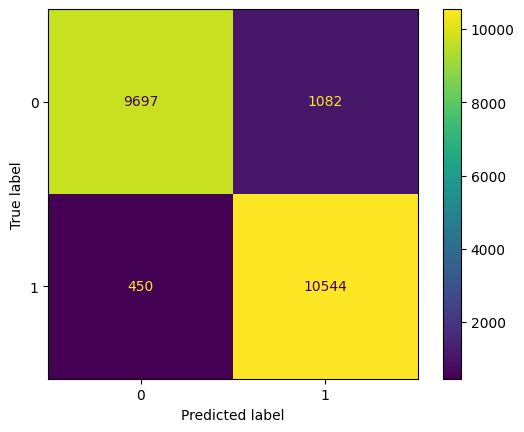

In [591]:
cm = confusion_matrix(df_train['label'], y_validation_pred_cv)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [592]:
X_test = df_train['text']

X_test_transformed_cv = CVEC.transform(X_test)
X_test_transformed_tf = TFVEC.transform(X_test)

y_test_pred_cv = model.predict(X_test_transformed_cv)
y_test_pred_tf = model.predict(X_test_transformed_tf)

21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [593]:
Y_test = df_train['label']
accuracy_test_cv = accuracy_score(Y_test, y_test_pred_cv)
accuracy_test_tf = accuracy_score(Y_test, y_test_pred_tf)

balanced_accuracy_test_cv = balanced_accuracy_score(Y_test, y_test_pred_cv)
balanced_accuracy_test_tf = balanced_accuracy_score(Y_test, y_test_pred_tf)

precision_test_cv = precision_score(Y_test, y_test_pred_cv)
precision_test_tf = precision_score(Y_test, y_test_pred_tf)


print("Using CV: ")
print("Accuracy:",round(100*accuracy_test_cv,2),'%')
print("Balanced accuracy:",round(100*balanced_accuracy_test_cv,2),'%')
print("Precision:", round(100*precision_test_cv,2),'%')

print("Using TF: ")
print("Accuracy:",round(100*accuracy_test_tf,2),'%')
print("Balanced accuracy:",round(100*balanced_accuracy_test_tf,2),'%')
print("Precision:", round(100*precision_test_tf,2),'%')

Using CV: 
Accuracy: 92.96 %
Balanced accuracy: 92.93 %
Precision: 90.69 %
Using TF: 
Accuracy: 94.85 %
Balanced accuracy: 94.82 %
Precision: 92.57 %


22. Create a confusion matrix using the **test dataset**

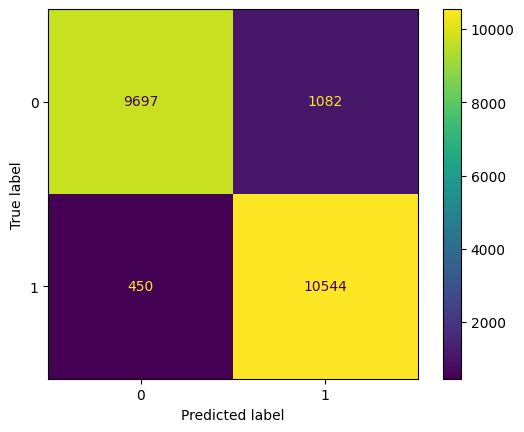

In [594]:
cm = confusion_matrix(df_train['label'], y_validation_pred_cv)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [595]:
to_predict = "ang saya saya ko ngayon tangina moo HAHAHA"
pred_transformed = CVEC.transform([to_predict])
prediction = model.predict(pred_transformed)

print("To predict: " + to_predict)
print("Prediction: ", prediction)

To predict: ang saya saya ko ngayon tangina moo HAHAHA
Prediction:  [0]


24. Test the model by providing a hate speech input. The model should predict it as 1

In [596]:
to_predict = "Ang init ng ulo ko ang gulo gulo ng paligid ang sarap talaga sumigaw ng putangina"
pred_transformed = CVEC.transform([to_predict])
prediction = model.predict(pred_transformed)

print("To predict: " + to_predict)
print("Prediction: ", prediction)

To predict: Ang init ng ulo ko ang gulo gulo ng paligid ang sarap talaga sumigaw ng putangina
Prediction:  [1]
